# Natural Language Processing: Kaggle's Tweet Disaster competition

This project is part of a Kaggle's competition and aims to develop abilities in Natural Language Processing (NLP) problems. Here, the objecive is to predict the occurance of real disasters through the words found in tweets from several places. Available data includes a train set (more detailed information bellow), and a test set. The full submission and final score can be checked at my personal page in Kaggle (to be updated here).

This notebook is inspired in some previous work published in Kaggle.

*References:*

- FeatureExtraction+RandomForestClassifier: https://www.kaggle.com/code/abdulaziz04/featureextraction-randomforestclassifier
- EDA+Preprocessing+Emedding+Model: https://www.kaggle.com/code/rakeshku1993/eda-preprocessing-emedding-model

### Importing the data and querying the first infomations

- **id** - a unique identifier for each tweet
- **text** - the text of the tweet
- **location** - the location the tweet was sent from (may be blank)
- **keyword** - a particular keyword from the tweet (may be blank)
- **target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
#Basic package
import pandas as pd

# Math and plot packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

# Text analysis packages
import re
import string
from nltk.corpus import words
from nltk.corpus import stopwords
from collections import defaultdict
from spellchecker import SpellChecker

# Encoders, tokenizers
import gensim
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from category_encoders import BinaryEncoder

In [2]:
train_data = pd.read_csv('train.csv')
test_data =  pd.read_csv('test.csv')

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Text(0.5, 1.0, 'Test set')

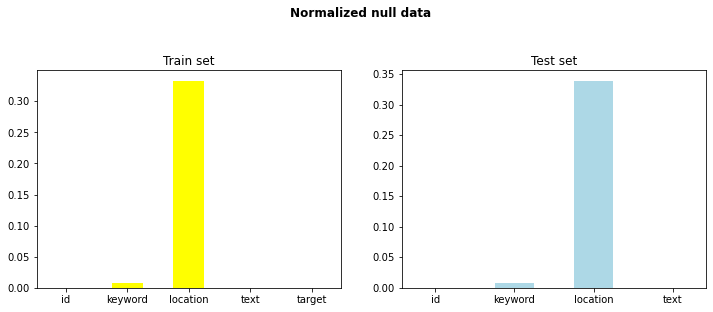

In [5]:
# Checking the amount of null information
trainNull = train_data.isnull().sum()
trainNull_percent = round(trainNull/train_data.shape[0], 3)

testNull = test_data.isnull().sum()
testNull_percent = round(testNull/test_data.shape[0], 3)

labels_train = trainNull.index
labels_test = testNull.index
width = 0.5

# Bar plot
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Normalized null data', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1.bar(labels_train, trainNull_percent, width, color='yellow')
ax1.set_title('Train set')
ax2.bar(labels_test, testNull_percent, width, color='lightblue')
ax2.set_title('Test set')

<AxesSubplot:>

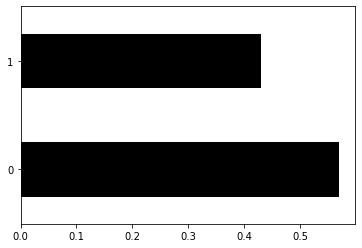

In [6]:
#Checking the balance between target classes
#(1 = real disaster, 0 = no disaster)

train_data['target'].value_counts(normalize=True).plot.barh(color='black')

Text(0.5, 1.0, 'Test set')

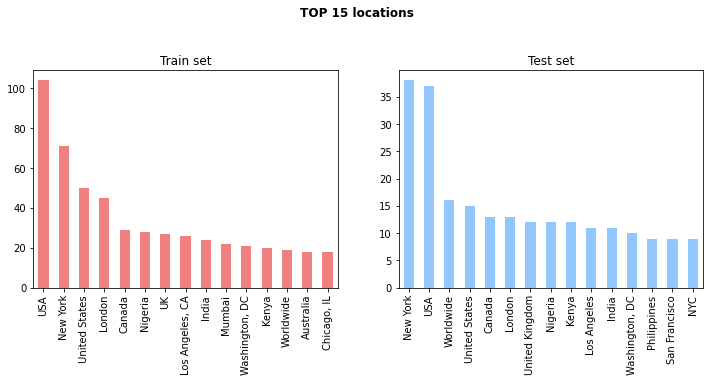

In [7]:
fig2,(ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig2.suptitle('TOP 15 locations', y=1.1, weight='bold', size='large')
plt.style.use('seaborn-pastel')

ax1 = train_data['location'].value_counts()[:15].plot.bar(ax=ax1, color='lightcoral')
ax1.set_title('Train set')
ax2 = test_data['location'].value_counts()[:15].plot.bar(ax=ax2)
ax2.set_title('Test set')

In [8]:
train_data.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Groton, CT               1
Asheboro, NC             1
Chiyoda Ward, Tokyo      1
Colorado Springs         1
Riverdale, GA            1
Name: location, Length: 3341, dtype: int64

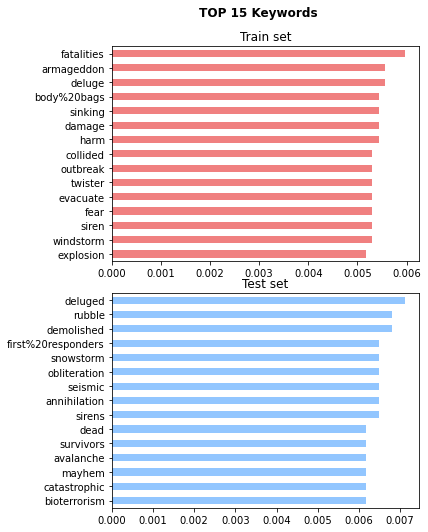

In [9]:
fig2,(ax1, ax2) = plt.subplots(2,1, figsize=(5,7))
fig2.tight_layout()
fig2.suptitle('TOP 15 Keywords', y=1.05, weight='bold', size='large')
plt.style.use('seaborn-pastel')


ax1 = train_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 color='lightcoral',
                                                                                 fontsize=10,
                                                                                 title='Train set',
                                                                                 ax=ax1)

ax2 = test_data['keyword'].value_counts(normalize=True)[:15].sort_values().plot(kind="barh",
                                                                                 fontsize=10,
                                                                                 title='Test set',
                                                                                 ax=ax2)

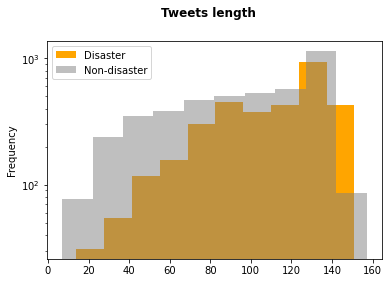

In [10]:
fig3,ax = plt.subplots() 
fig3.figsize=(12,4)
fig3.suptitle('Tweets length', y=1, weight='bold', size='large')

ax = train_data.query("target==1")["text"].str.len().plot(kind="hist",
                                                           color="orange",
                                                           ax=ax)

ax = train_data.query("target==0")["text"].str.len().plot(kind="hist",
                                                           color="gray",
                                                           alpha=0.5,
                                                           ax=ax)
ax.set_yscale('log')
ax.legend(['Disaster', 'Non-disaster'])

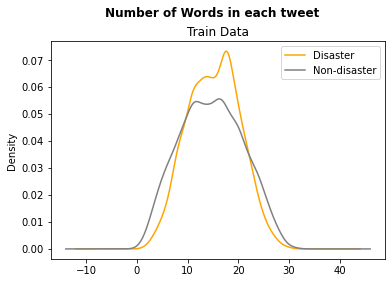

In [11]:
fig4,ax = plt.subplots()
fig4.figsize=(12,4)
fig4.suptitle('Number of Words in each tweet', y=1, weight='bold', size='large')
ax.set_title('Train Data', y=1, weight='light', size='large')

ax = train_data.query("target==1").text.map(lambda x: len(x.split())).plot(kind="kde",
                                                                            color="orange",
                                                                            ax=ax)

ax = train_data.query("target==0").text.map(lambda x: len(x.split())).plot(kind="kde",
                                                                            color="gray",
                                                                            ax=ax)
ax.legend(['Disaster', 'Non-disaster'])

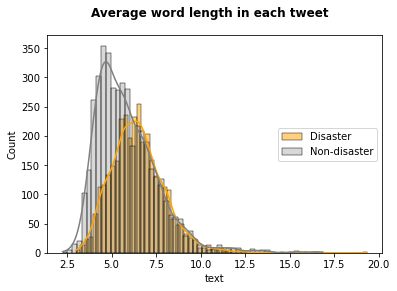

In [12]:
fig5, ax = plt.subplots()
fig5.figsize=(12,5)
fig5.suptitle('Average word length in each tweet', weight='bold')

each_words_len = train_data.query("target==1").text.str.split().map(lambda x: [len(i) for i in x])
sns.histplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=ax, color="orange", label='Disaster');

each_words_len = train_data.query("target==0").text.str.split().map(lambda x: [len(i) for i in x])
sns.histplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=ax, color='gray', alpha=0.3,  label='Non-disaster');
ax.legend(loc='right')

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def plot_punctuations(df, target):
    
    punctations_dict = defaultdict(int)
    
    for idx, text in df[df["target"]==target].text.iteritems():
        for token in text.split():
            if token in string.punctuation:
                punctations_dict[token] +=1   

    return dict(sorted(punctations_dict.items(), key=lambda x: x[1], reverse=True))


dt_punctuations = plot_punctuations(train_data, target=1)
ndt_punctuations = plot_punctuations(train_data, target=0)

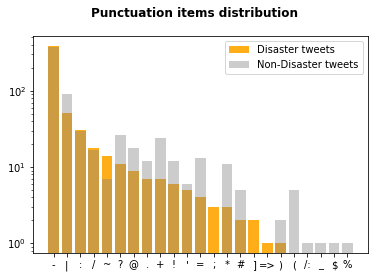

In [15]:
fig6, ax = plt.subplots()
fig6.figsize=(12,5)
fig6.suptitle('Punctuation items distribution', weight='bold')

x1, y1 = zip(*dt_punctuations.items())
ax.bar(x1, y1, color="orange", alpha=0.9, label="Disaster tweets")

x2, y2 = zip(*ndt_punctuations.items())
ax.bar(x2, y2, color="gray", alpha=0.4, label="Non-Disaster tweets")
ax.legend()
ax.set_yscale('log')

In [16]:
stop_words= set(stopwords.words("english"))

# updating the stopwords considering the following list
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color= "black", 
               colormap="Paired",
               max_font_size=150)

In order to plot de the word cloud, we will use the method **plt.imshow**. According to matplotlib documentation: *Display data as an image, i.e., on a 2D regular raster. The input may either be actual RGB(A) data, or 2D scalar data, which will be rendered as a pseudocolor image.*


Word Cloud for Disaster Tweets


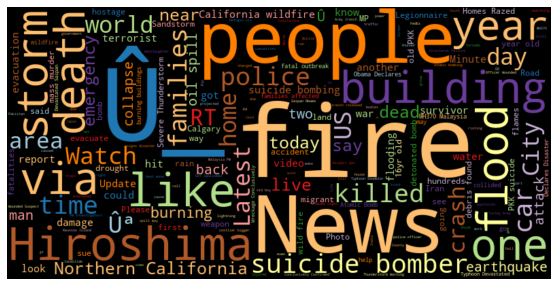


Word Cloud for Non-Disaster Tweets


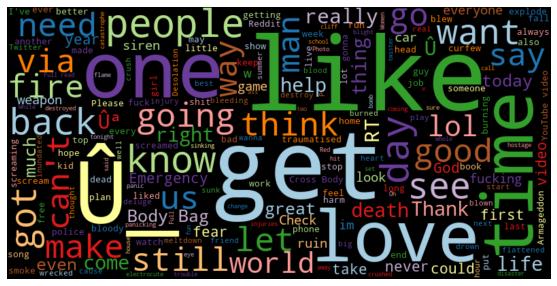

In [17]:
disaster_tweets = (train_data.query("target==1").text).str.cat(sep=" ")  # str.cat -- string concatenation

non_disaster_tweets = (train_data.query("target==0").text).str.cat(sep=" ")

print('\033[1m'"\nWord Cloud for Disaster Tweets"'\033[0m')
wc.generate(disaster_tweets)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\033[1m'"\nWord Cloud for Non-Disaster Tweets"'\033[0m')
wc.generate(non_disaster_tweets)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Feature Engineering

**TASK 1:** tweet length (in number of chars)

In [18]:
train_data['num chars'] = train_data["text"].str.len().values
test_data['num chars']  = test_data["text"].str.len().values

In [19]:
train_data.head(2)

,id,keyword,location,text,target,num chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38


In [20]:
test_data.head(2)

,id,keyword,location,text,num chars
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64


**TASK 2:** number of special chars

In [21]:
def count_special_chars(df):
    
    '''
    Uses regex to identify special chars in text. 
    [^a-zA-Z0-9\s] means: anything in the interval [] that is NOT (^): [a-z] or [A-Z] or [0-9] or \s (space)
    
    Parameters:
        df: Dataset
    Returns: 
        A list with the amount of special chars for each example of the dataset
    
    '''
    special_chars=[]
    
    for text in df['text']:
        special_chars.append(len(re.findall(r'[^a-zA-Z0-9\s]', text)))
    
    return special_chars

In [22]:
train_data['num special chars'] = count_special_chars(train_data)
test_data['num special chars']  =  count_special_chars(test_data)

In [23]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3


In [24]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars
0,0,NaN,NaN,Just happened a terrible car crash,34,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2


**TASK 3:** number of words in each tweet

In [25]:
train_data['num words'] = train_data["text"].map(lambda x: len(x.split()))
test_data['num words']  = test_data["text"].map(lambda x: len(x.split()))

In [26]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3,22


In [27]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars,num words
0,0,NaN,NaN,Just happened a terrible car crash,34,0,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2,19


**TASK 4:** average word length

In [28]:
def average_word_length(text):
    
    '''Reads each sentence and creates a list with word lenghts. Following, it returns the mean of the 
    list values'''
    
    spl_text = text.split()
    each_words_len = list(map(lambda x: len(x), spl_text))
    mean = round(sum(each_words_len)/len(each_words_len), 2)
    
    return mean

In [29]:
train_data['average word length'] = train_data["text"].apply(lambda x: average_word_length(x))
test_data['average word length']  = test_data["text"].apply(lambda x: average_word_length(x))

In [30]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words,average word length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13,4.38
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7,4.57
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3,22,5.09


In [31]:
test_data.head(3)

,id,keyword,location,text,num chars,num special chars,num words,average word length
0,0,NaN,NaN,Just happened a terrible car crash,34,0,6,4.83
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64,3,9,6.22
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96,2,19,4.11


**TASK 5:** standardize location representations

In [32]:
def split_location_countries(df):
    
    countries=[]
    location=[]
    
    for item in df['location'].astype(str).values:
        countries.append(item.split(',')[-1])
        location.append(item.split(',')[0])
        
    df['country']  = countries
    df['location'] = location
    
    assert len(countries)==df.shape[0]
    assert len(countries)==df.shape[0]
        
    return df

In [33]:
train_data = split_location_countries(train_data)
test_data  = split_location_countries(test_data)

In [34]:
def remove_special_chars(text):
    
    '''
    The function removes any char that is not a word character (uppercase or lowercase) and replaces it for
    a simple blank space.
    The regular expression [^a-zA-Z] matches any char that is NOT(^) a word (like special chars, space or
    numbers).
    '''
    
    return re.sub(r"[^a-zA-Z]", " ", text)

In [35]:
train_data['location'] = train_data.location.apply(lambda x: remove_special_chars(x))
test_data['location']  = test_data.location.apply(lambda x: remove_special_chars(x))
train_data['country'] = train_data.location.apply(lambda x: remove_special_chars(x))
test_data['country']  = test_data.location.apply(lambda x: remove_special_chars(x))

In [36]:
train_data.country.value_counts()

nan                         2533
USA                          108
New York                      95
London                        70
United States                 50
                            ... 
S F  Bay area                  1
Antarctica                     1
In the clouds                  1
 Quantico Marine Base          1
Freddy Fazbears pizzeria       1
Name: country, Length: 2863, dtype: int64

In [37]:
train_data.location.value_counts()

nan                         2533
USA                          108
New York                      95
London                        70
United States                 50
                            ... 
S F  Bay area                  1
Antarctica                     1
In the clouds                  1
 Quantico Marine Base          1
Freddy Fazbears pizzeria       1
Name: location, Length: 2863, dtype: int64

Importing a table with most important cities in the world to standardize the countries notation

In [38]:
cities = pd.read_csv('worldcities.csv')
cities['city_ascii'] = cities['city_ascii'].str.lower()
cities.head(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604


In [39]:
columns = ['location', 'country']
for column in columns:
    train_data[column] = train_data[column].str.lower()
    test_data[column]  = test_data[column].str.lower()

In [40]:
def discover_country_from_city(df, column, cities_df):
    
    '''
    Splits the location field and searches for the name of cities to find their respective country
    '''
     
    index=0
    for item in df[column]:
        
        for new_item in item.split():
            if (new_item != 'nan') and (new_item in cities_df['city_ascii'].values):
                df.loc[index, 'country'] = cities_df[cities_df['city_ascii']==new_item].iso2.values[0]
        else:
            pass
        
        index+=1
    
    return df

In [41]:
for colum in columns:
    train_data = discover_country_from_city(train_data, column, cities)
    test_data  = discover_country_from_city(test_data, column, cities)

In [42]:
train_data.country.value_counts()

nan                          2533
US                           1349
GB                            287
JP                            152
CA                            134
                             ... 
all around the world            1
a sofa                          1
ebola                           1
score more goals buying         1
dagenham                        1
Name: country, Length: 1567, dtype: int64

In [43]:
train_data[500:504]

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country
500,725,attacked,lealman,Christian Attacked by Muslims at the Temple Mo...,1,122,9,18,5.83,US
501,726,attacked,los angeles,@envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...,0,136,7,21,5.48,los angeles
502,727,attacked,san francisco,Kelly Osbourne attacked for racist Donald Trum...,1,103,5,14,6.43,ML
503,728,attacked,gdjb asot,@eunice_njoki aiii she needs to chill and answ...,0,89,3,15,5.00,gdjb asot


Cities with double names are affected when we split the location field. To solve it, let's search for the full name of the cities

In [44]:
def discover_country_from_city_v2(df, column, cities_df):
    
    '''
    Uses the location field **with no splitting** and searches for the name of cities to find their 
    respective country
    '''
     
    index=0
    
    for item in df[column]:
        
        if (item != 'nan') and (item in cities_df['city_ascii'].values):
                df.loc[index, 'country'] = cities_df[cities_df['city_ascii']==item].iso2.values[0]
        else:
            pass
        
        index+=1
    
    return df

In [45]:
for column in columns:
    train_data = discover_country_from_city_v2(train_data, column, cities)
    test_data  = discover_country_from_city_v2(test_data, column, cities)

In [46]:
train_data.country.value_counts()

nan            2533
US             1540
GB              290
JP              152
CA              135
               ... 
city of joy       1
n   y             1
spain             1
edappally         1
dagenham          1
Name: country, Length: 1503, dtype: int64

In [47]:
train_data[500:504]

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country
500,725,attacked,lealman,Christian Attacked by Muslims at the Temple Mo...,1,122,9,18,5.83,US
501,726,attacked,los angeles,@envw98 @NickCoCoFree @JulieDiCaro @jdabe80 Wh...,0,136,7,21,5.48,US
502,727,attacked,san francisco,Kelly Osbourne attacked for racist Donald Trum...,1,103,5,14,6.43,US
503,728,attacked,gdjb asot,@eunice_njoki aiii she needs to chill and answ...,0,89,3,15,5.00,gdjb asot


As we have a huge presence of US locations, let us import a USA database with states and main cities

In [48]:
usa_data = pd.read_csv('USAData.csv')

In [49]:
usa_columns = ['name', 'usps', 'State']
for column in usa_columns:
    usa_data[column] = usa_data[column].str.lower()

usa_data.head()

,rank,name,usps,pop2022,pop2010,growth,density,aland_sqmi,State
0,1,new york city,ny,8930002,8175133,0.0923,29729,300.381,new york
1,2,los angeles,ca,3919973,3792621,0.0336,8359,468.956,california
2,3,chicago,il,2756546,2695598,0.0226,12124,227.369,illinois
3,4,houston,tx,2345606,2099451,0.1172,3664,640.194,texas
4,5,phoenix,az,1640641,1445632,0.1349,3169,517.673,arizona


In [50]:
def find_USA_locations(df, column, cities_df):
    
    '''
    Finds USA locations and replace them by 'US' name in country field
    '''
    
    index=0
    usa_columns = ['State', 'usps', 'name']
    
    for item in df[column]:
        
        if item in ['new york', 'united states']:
            df.loc[index, 'country'] = 'US'
        
        else:
            for usa_column in usa_columns:
                if item in cities_df[usa_column].values:
                    df.loc[index, 'country'] = 'US'
                    df.loc[index, 'location']= item
                
                else:
                    pass
        
        index+=1
    
    return df

In [51]:
for column in columns:
    train_data = find_USA_locations(train_data, column, usa_data)
    test_data  = find_USA_locations(test_data, column, usa_data)

In [52]:
train_data.country.value_counts()

nan                              2533
US                               1833
GB                                281
JP                                152
CA                                122
                                 ... 
n   y                               1
spain                               1
edappally                           1
follows you everywhere you go       1
dagenham                            1
Name: country, Length: 1456, dtype: int64

In [53]:
def find_USA_locations_v2(df, column, cities_df):
    
    '''
    Splits the entries to find US locations
    '''
     
    index=0
    usa_columns = ['State', 'usps', 'name']
    for item in df[column]:
        
        for new_item in item.split():
            for usa_column in usa_columns:
                if new_item in cities_df[usa_column].values:
                    df.loc[index, 'country'] = 'US'
        else:
            pass
        
        index+=1
    
    return df

In [54]:
for column in columns:
    train_data = find_USA_locations_v2(train_data, column, usa_data)
    test_data  = find_USA_locations_v2(test_data, column, usa_data)

In [55]:
train_data.country.value_counts()

nan                    2533
US                     2048
GB                      272
JP                      138
CA                      112
                       ... 
buscame el tu melte       1
city of joy               1
n   y                     1
spain                     1
dagenham                  1
Name: country, Length: 1341, dtype: int64

In [56]:
train_data.location.value_counts()

nan                         2533
usa                          108
new york                     100
london                        74
united states                 50
                            ... 
wandsworth                     1
  t                            1
me mammy s belly               1
                               1
delhi                          1
Name: location, Length: 2741, dtype: int64

As our Cities database does not comprise all countries in the world, let us import a last, but complete country dataset and search for remaining entries...

In [57]:
countries = pd.read_csv('All countries.csv')

In [58]:
countries['country'] = countries['country'].str.lower()
countries['abbreviation'] = countries['abbreviation'].str.lower()

In [59]:
countries.head()

,abbreviation,country
0,af,afghanistan
1,ax,aland islands
2,al,albania
3,dz,algeria
4,as,american samoa


In [60]:
def search_remaining_countries(df, column, countries_df):
    '''
    Splits the entries to find US locations
    '''
     
    index=0
    for item in df[column]:
        
        if item in countries_df['country'].values:
            df.loc[index, 'country'] = countries_df[countries_df['country']==item].abbreviation.values[0]
        
        else:
            pass
        
        index+=1
    
    return df

In [61]:
train_data = search_remaining_countries(train_data, 'country', countries)
test_data  = search_remaining_countries(test_data, 'country', countries)

In [62]:
train_data.country.value_counts()

nan                      2533
US                       2048
GB                        272
JP                        138
CA                        112
                         ... 
edappally                   1
all around the world        1
a sofa                      1
ebola                       1
dagenham                    1
Name: country, Length: 1340, dtype: int64

As we achieved less variation in ['country'] data than in the original ['location'] field, let us work with ['country'] feature from now on. 

To standardize it, the entries with **len(country)>3** and those which does not match any real country abbreviation will be tagged as NaN, as their location is mostly fake and brings no relevant information

In [63]:
def replace_with_nan_v1(df):
    
    '''This version 1 (v1) replaces entries with len()>3 for 'nan' values'''
    
    
    df['country']= np.where(df.country.str.len()>3, 'nan', df['country'])
    
    return df

In [64]:
train_data = replace_with_nan_v1(train_data)
test_data  = replace_with_nan_v1(test_data)

In [65]:
def replace_with_nan_v2(df, countries_df):
    
    '''This version 2 (v2) searches for countries abbreviations in the dataframe ['country'] entries. If an 
    entry does not match an existing country abbreviation, it is replaced by a 'nan' value'''
         
    index=0
    for item in df['country']:
        
        if (item != 'nan') and (item in countries_df['abbreviation'].values):
            pass
        
        else:
            df.loc[index, 'country'] = 'nan'
        
        index+=1
    
    return df

In [66]:
train_data = replace_with_nan_v2(train_data, countries)
test_data  = replace_with_nan_v2(test_data, countries)

In [67]:
train_data.country.value_counts().shape

(64,)

In [68]:
test_data.country.value_counts().shape

(32,)

In [69]:
train_data['country'] = train_data['country'].str.upper()
test_data['country']  = test_data['country'].str.upper()

**TASK 4:** 

**TASK 4:** Encode country and keywords

To encode **['country']**, we choose **Frequency Encoding**. As briefly explained in this post (https://towardsdatascience.com/how-to-encode-categorical-data-d44dde313131), this gives the probability of each class. Given the huge amount of possible locations, and the different frequencies distributions, we avoid a large matrix in conventional encoding plus inform the 'weight' of each place.

In [70]:
# Group it by type, find the size of each type, and divide by total event

# Train data ("fit_transform")
country_train_freq = train_data.groupby("country").size()/len(train_data)
train_data['country freq'] = train_data['country'].map(country_train_freq) 

# Test data ("transform")
test_data['country freq'] = test_data['country'].map(country_train_freq) 

In [71]:
# Some countries may not appear in the test set. Let us fulfill them with 0 values
countries_id = list(set(test_data['country'].values).difference(set(country_train_freq.index)))
values = [0]*len(countries_id)

assert len(countries_id)==len(values)

exceptions = dict(zip(countries_id, values))

In [72]:
# Correcting these cases one by one..
test_data['country freq'] = test_data['country freq'].map(exceptions)

To encode **['keywords']**, we choose conventional **Binary Encoding**.

In [73]:
def binary_encoder(df, column):
    
    be = BinaryEncoder(cols=[column])
    newdata = be.fit_transform(df[column])
    
    assert newdata.shape[0]==df.shape[0]
    
    df = pd.concat([df, newdata], axis=1)
    
    return df

In [74]:
train_data = binary_encoder(train_data, 'keyword')
test_data  = binary_encoder(test_data, 'keyword')

In [75]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7
0,1,NaN,nan,Our Deeds are the Reason of this #earthquake M...,1,69,1,13,4.38,NAN,0.959149,0,0,0,0,0,0,0,1
1,4,NaN,nan,Forest fire near La Ronge Sask. Canada,1,38,1,7,4.57,NAN,0.959149,0,0,0,0,0,0,0,1
2,5,NaN,nan,All residents asked to 'shelter in place' are ...,1,133,3,22,5.09,NAN,0.959149,0,0,0,0,0,0,0,1


**TASK 5:** Text cleaning and tokenizing

In [76]:
train_data['text']  = train_data['text'].apply(lambda x : remove_special_chars(x))
test_data['text']   = test_data['text'].apply(lambda x : remove_special_chars(x))

In [77]:
train_data.text

0       Our Deeds are the Reason of this  earthquake M...
1                  Forest fire near La Ronge Sask  Canada
2       All residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       Just got sent this photo from Ruby  Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609     aria ahrary  TheTawniest The out of control w...
7610    M            UTC   km S of Volcano Hawaii  htt...
7611    Police investigating after an e bike collided ...
7612    The Latest  More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

**Methods for stopwords**

In [78]:
import spacy
en = spacy.load('en_core_web_sm')
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Text(0.5, 1.1, 'Stopwords packages - Size comparison')

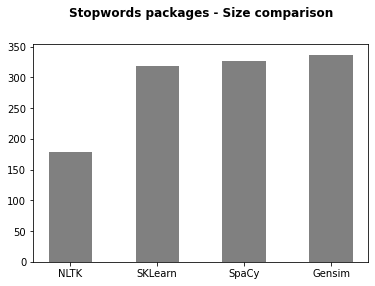

In [79]:
#NLTK
sw_nltk = stopwords.words('english')
nltk_size = len(sw_nltk)

#SKLEARN
sklearn_size = len(ENGLISH_STOP_WORDS)

#GENSIM
gensim_size = len(STOPWORDS)

#SPACY
sw_spacy = en.Defaults.stop_words
spacy_size = len(sw_spacy)

x_values = [nltk_size, sklearn_size, spacy_size, gensim_size]
labels = ['NLTK', 'SKLearn', 'SpaCy', 'Gensim']
width = 0.5

# Bar plot
fig7,ax = plt.subplots()
fig7.figsize=(12,4)

ax.bar(labels, x_values, width, color='gray')
ax.set_title('Stopwords packages - Size comparison', y=1.1, weight='bold', size='large')

In [80]:
spell = SpellChecker()

def correct_spellings(text):
    
    '''Corrects mispelling words'''
    
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
            
    return " ".join(corrected_text)

In [81]:
train_data['text']  = train_data['text'].apply(lambda x : correct_spellings(x))
test_data['text']   = test_data['text'].apply(lambda x : correct_spellings(x))

Creating a backup for future use

In [82]:
# Backup
train_copy = train_data.copy()
test_copy  = test_data.copy()

In [83]:
train_data['text'] = train_data['text'].str.lower()
test_data['text']  = test_data['text'].str.lower()

In [84]:
def gensim_with_lemmantizer(text):
    
    '''Removes stop words and non-English vocabulary using Gensim package and performs lemmatization'''
    
    # Remove stopwords
    clean_text = remove_stopwords(text)
        
    # setting English vocabulary
    english_vocab = set(w.lower() for w in words.words())
    
    # Removing non-English vocabulary
    clean_text = word_tokenize(clean_text)
    tokens = [word for word in clean_text if word in english_vocab]
    
    # Tokenize and Lemmatizing
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        clean_tokens.append(lemmatizer.lemmatize(token).lower().strip())
     
    return " ".join(clean_tokens)

In [85]:
train_data['text']  = train_data['text'].apply(lambda x : gensim_with_lemmantizer(x))
test_data['text']   = test_data['text'].apply(lambda x : gensim_with_lemmantizer(x))

In [86]:
train_data.head(3)

,id,keyword,location,text,target,num chars,num special chars,num words,average word length,country,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7
0,1,NaN,nan,reason earthquake allah forgive,1,69,1,13,4.38,NAN,0.959149,0,0,0,0,0,0,0,1
1,4,NaN,nan,forest near la canada,1,38,1,7,4.57,NAN,0.959149,0,0,0,0,0,0,0,1
2,5,NaN,nan,shelter place notified evacuation shelter place,1,133,3,22,5.09,NAN,0.959149,0,0,0,0,0,0,0,1


### Training some ML models

Let us try some different methods for vectorizing texts.

**First one will be: RF + 'text' encoded with TD-IDF.**

**TfidfVectorizer** is a method from *feature_extraction* for texts available in Scikit Learn. According to the documentation:

- Convert a collection of raw documents to a matrix of TF-IDF features. Equivalent to *CountVectorizer* followed by *TfidfTransformer*.

The last one, according to Scikit Learn documentation:

- Transform a count matrix to a normalized tf or tf-idf representation.
- **Tf** means *term-frequency* while **tf-idf** means *term-frequency times inverse document-frequency*. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

In [87]:
# Pre processing
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

# Methods
from sklearn.ensemble import RandomForestClassifier

In [88]:
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)

# For Train Set
train_texts = vectorizer.fit_transform(train_data['text'])
train_texts = pd.DataFrame(train_texts.toarray(), columns=vectorizer.get_feature_names_out())


# For Test Set
test_texts  = vectorizer.transform(test_data['text'])
test_texts  = pd.DataFrame(test_texts.toarray(), columns=vectorizer.get_feature_names_out())

In [89]:
# Generating final sets

# Train Set
xtrain = pd.concat([train_data, train_texts], axis=1).drop(columns=['id', 'keyword', 'location', 
                                                                    'text', 'country', 'target'])

ytrain = train_data['target']

# Test Set
xtest = pd.concat([test_data, test_texts], axis=1).drop(columns=['id', 'keyword', 'location', 
                                                                 'text', 'country'])

In [90]:
xtrain.head(3)

,num chars,num special chars,num words,average word length,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,...,zionism,zionist,zip,zipper,zo,zodiac,zombie,zone,zoo,zoom
0,69,1,13,4.38,0.959149,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38,1,7,4.57,0.959149,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,3,22,5.09,0.959149,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# Spitting datasets
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.15, random_state=42)

# initiate the ML model using Gini Impurity algorithm (default)
RF = RandomForestClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline([("RF", RF)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"RF__n_estimators": [100, 150, 200],
              "RF__max_depth":[7, 10, 15],
             } 

scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search.fit(xtrain, ytrain)
results = search.cv_results_
method = search.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid.shape)
print('Y validation size:', yvalid.shape)
print('X test size:', xtest.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print("Best parameters: ", search.best_params_)
print("Best index: ", search.best_index_)
print("Best estimator: ", search.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
------ Train, Validation and Test sets info ------
X train size: (6471, 7190)
Y train size: (6471,)
X validation size: (1142, 7190)
Y validation size: (1142,)
X test size: (3263, 7191)
------ Grid search model selection info ------
Best parameter (CV score=0.797):
Best parameters:  {'RF__max_depth': 15, 'RF__n_estimators': 100}
Best index:  6
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=15))])


In [92]:
ypredproba_RF = method.predict_proba(xvalid)
ypred_RF = method.predict(xvalid)

**LGBM + 'text' encoded with TF-IDF**

In [93]:
# Generating final sets

# Train Set
xtrain7 = pd.concat([train_data, train_texts], axis=1).drop(columns=['id', 'keyword', 'location', 
                                                                    'text', 'country', 'target'])

ytrain = train_data['target']

# Test Set
xtest7 = pd.concat([test_data, test_texts], axis=1).drop(columns=['id', 'keyword', 'location', 
                                                                 'text', 'country'])

In [94]:
xtrain7.head(3)

,num chars,num special chars,num words,average word length,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,...,zionism,zionist,zip,zipper,zo,zodiac,zombie,zone,zoo,zoom
0,69,1,13,4.38,0.959149,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38,1,7,4.57,0.959149,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,3,22,5.09,0.959149,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
from lightgbm import LGBMClassifier

In [96]:
# Spitting datasets
xtrain7, xvalid7, ytrain, yvalid7 = train_test_split(xtrain7, ytrain, test_size=0.15, random_state=42)

# initiate the ML model using Gini Impurity algorithm (default)
LGBM = LGBMClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline([("LGBM", LGBM)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3, 5, 10]
             } 

scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search7 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search7.fit(xtrain7, ytrain)
results7 = search7.cv_results_
method7 = search7.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain7.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid7.shape)
print('Y validation size:', yvalid7.shape)
print('X test size:', xtest7.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search7.best_score_)
print("Best parameters: ", search7.best_params_)
print("Best index: ", search7.best_index_)
print("Best estimator: ", search7.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
------ Train, Validation and Test sets info ------
X train size: (6471, 7190)
Y train size: (6471,)
X validation size: (1142, 7190)
Y validation size: (1142,)
X test size: (3263, 7191)
------ Grid search model selection info ------
Best parameter (CV score=0.823):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 10, 'LGBM__n_estimators': 100}
Best index:  26
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=10))])


In [97]:
ypredproba_RF = method.predict_proba(xvalid7)
ypred_RF = method.predict(xvalid7)

This time, instead of performing encoding with TF-IDF, we will vectorize the 'text' feature using SpaCy pre-trained embbeding.

**RF + 'text' encoded with SpaCy**

In [98]:
# Load the spacy model that you have installed
nlp = spacy.load('en_core_web_md')

In [99]:
class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_core_web_md"):
        self.model = model

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

In [100]:
transformer = WordVectorTransformer()
train_arr = transformer.fit_transform(train_data['text'])
test_arr  = transformer.fit_transform(test_data['text'])

In [101]:
df_train_txt = pd.DataFrame(train_arr, columns =['txt'+str(i) for i in range(1,301)])
df_test_txt  = pd.DataFrame(test_arr, columns =['txt'+str(i) for i in range(1,301)])

In [102]:
# Generating final sets

# Train Set
xtrain2 = pd.concat([train_data, df_train_txt], axis=1).drop(columns=['id', 'keyword', 'location',
                                                                   'text', 'country', 'target'])


ytrain = train_data['target']

# Test Set
xtest2 = pd.concat([test_data, df_test_txt], axis=1).drop(columns=['id', 'keyword', 'location', 
                                                                'text', 'country'])

In [103]:
xtrain2.columns

Index(['num chars', 'num special chars', 'num words', 'average word length',
       'country freq', 'keyword_0', 'keyword_1', 'keyword_2', 'keyword_3',
       'keyword_4',
       ...
       'txt291', 'txt292', 'txt293', 'txt294', 'txt295', 'txt296', 'txt297',
       'txt298', 'txt299', 'txt300'],
      dtype='object', length=313)

In [104]:
xtrain2.head(3)

,num chars,num special chars,num words,average word length,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,...,txt291,txt292,txt293,txt294,txt295,txt296,txt297,txt298,txt299,txt300
0,69,1,13,4.38,0.959149,0,0,0,0,0,...,3.753675,-0.973575,0.807835,-0.427525,-0.404525,1.622118,1.224605,-0.881025,-2.046537,1.265052
1,38,1,7,4.57,0.959149,0,0,0,0,0,...,-1.024685,2.021043,4.444325,1.457075,0.132725,1.300485,1.729575,-0.197270,-0.915400,-2.731612
2,133,3,22,5.09,0.959149,0,0,0,0,0,...,-0.725623,-1.385352,0.817780,2.724800,-4.064633,-0.608247,-1.015070,-1.789082,0.803580,0.772050


In [105]:
%time
# Spitting datasets
xtrain2, xvalid2, ytrain, yvalid2 = train_test_split(xtrain2, ytrain, test_size=0.15, random_state=42)

# initiate the ML model using Gini Impurity algorithm (default)
RF = RandomForestClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline([("RF", RF)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"RF__n_estimators": [100, 150, 200],
              "RF__max_depth":[7, 10, 15],
             } 

scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search2 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search2.fit(xtrain2, ytrain)
results2 = search2.cv_results_
method2 = search2.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain2.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid2.shape)
print('Y validation size:', yvalid2.shape)
print('X test size:', xtest2.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search2.best_score_)
print("Best parameters: ", search2.best_params_)
print("Best index: ", search2.best_index_)
print("Best estimator: ", search2.best_estimator_)

CPU times: user 0 ns, sys: 11 µs, total: 11 µs
Wall time: 20.3 µs
Fitting 5 folds for each of 9 candidates, totalling 45 fits
------ Train, Validation and Test sets info ------
X train size: (6471, 313)
Y train size: (6471,)
X validation size: (1142, 313)
Y validation size: (1142,)
X test size: (3263, 313)
------ Grid search model selection info ------
Best parameter (CV score=0.815):
Best parameters:  {'RF__max_depth': 10, 'RF__n_estimators': 150}
Best index:  4
Best estimator:  Pipeline(steps=[('RF', RandomForestClassifier(max_depth=10, n_estimators=150))])


In [106]:
ypredproba2_RF = method2.predict_proba(xvalid2)
ypred2_RF      = method2.predict(xvalid2)

**Let us try another ML model: LGBM + 'text' encoding with SpaCy**

In [107]:
xtrain3 = xtrain2.copy()
xtest3 = xtest2.copy()

In [108]:
xtrain3.head(3)

,num chars,num special chars,num words,average word length,country freq,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,...,txt291,txt292,txt293,txt294,txt295,txt296,txt297,txt298,txt299,txt300
2318,139,9,19,6.37,0.959149,0,1,0,0,0,...,-0.312002,-0.016643,-2.041475,-0.959840,-2.839250,-0.583513,-0.374825,-2.471025,-0.988960,-0.452226
6341,140,10,14,9.00,0.959149,1,0,1,1,1,...,0.136846,-0.506920,0.094750,1.321641,0.026958,0.138392,-0.702416,-3.217886,-0.089883,2.108547
1097,82,8,10,7.30,0.959149,0,0,1,0,0,...,2.819352,-1.163960,-0.505273,0.845528,0.689454,-0.813842,-0.638542,0.618172,-2.917960,1.738954


In [109]:
# Splitting datasets
xtrain3, xvalid3, ytrain, yvalid3 = train_test_split(xtrain3, ytrain, test_size=0.15, random_state=42)

# initiate the ML model using Gini Impurity algorithm (default)
LGBM = LGBMClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline([("LGBM", LGBM)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3, 5, 10]
             } 


scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search3 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search3.fit(xtrain3, ytrain)
results3 = search3.cv_results_
method3 = search3.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain3.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid3.shape)
print('Y validation size:', yvalid3.shape)
print('X test size:', xtest3.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search3.best_score_)
print("Best parameters: ", search3.best_params_)
print("Best index: ", search3.best_index_)
print("Best estimator: ", search3.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
------ Train, Validation and Test sets info ------
X train size: (5500, 313)
Y train size: (5500,)
X validation size: (971, 313)
Y validation size: (971,)
X test size: (3263, 313)
------ Grid search model selection info ------
Best parameter (CV score=0.822):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 10, 'LGBM__n_estimators': 100}
Best index:  26
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=10))])


In [110]:
ypredproba3_RF = method3.predict_proba(xvalid3)
ypred3_RF      = method3.predict(xvalid3)

Now, let us try a new approach to keywords encoding..

**LGBM + 'text' and 'keywords' encoded with SpaCy...**

In [111]:
train_data['keyword'] = np.where(train_data['keyword'].isnull()==True, 'NA', train_data['keyword'])
test_data['keyword']  = np.where(test_data['keyword'].isnull()==True, 'NA', test_data['keyword'])

In [112]:
train_data['keyword'].value_counts()

NA                       61
fatalities               45
armageddon               42
deluge                   42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [113]:
train_data['keyword']  = train_data['keyword'].apply(lambda x : remove_special_chars(x))
test_data['keyword']   = test_data['keyword'].apply(lambda x : remove_special_chars(x))

In [114]:
transformer = WordVectorTransformer()
train_arr_key = transformer.fit_transform(train_data['keyword'])
test_arr_key  = transformer.fit_transform(test_data['keyword'])

In [115]:
df_train_key = pd.DataFrame(train_arr_key, columns =['key'+str(i) for i in range(1,301)])
df_test_key  = pd.DataFrame(test_arr_key, columns =['key'+str(i) for i in range(1,301)])

In [116]:
# Generating final sets

# Train Set
xtrain4 = pd.concat([xtrain2, df_train_key], axis=1).drop(columns=['keyword_0', 'keyword_1', 'keyword_2',
                                                                   'keyword_3', 'keyword_4', 'keyword_5',
                                                                   'keyword_6', 'keyword_7'])


ytrain = train_data['target']

# Test Set
xtest4 = pd.concat([xtest2, df_test_key], axis=1).drop(columns=['keyword_0', 'keyword_1', 'keyword_2', 
                                                                'keyword_3', 'keyword_4', 'keyword_5', 
                                                                'keyword_6', 'keyword_7'])

In [117]:
xtrain4.head(3)

,num chars,num special chars,num words,average word length,country freq,txt1,txt2,txt3,txt4,txt5,...,key291,key292,key293,key294,key295,key296,key297,key298,key299,key300
0,69.0,1.0,13.0,4.38,0.959149,0.555505,0.154475,-1.086337,-0.618830,0.499290,...,-3.1571,0.62379,-10.119,3.6885,4.2304,-2.4684,0.42019,-5.4629,-3.3201,2.1971
1,38.0,1.0,7.0,4.57,0.959149,0.539290,-2.217692,-2.436538,-1.089285,3.347662,...,-3.1571,0.62379,-10.119,3.6885,4.2304,-2.4684,0.42019,-5.4629,-3.3201,2.1971
2,133.0,3.0,22.0,5.09,0.959149,-1.316240,0.479103,-0.478980,1.251125,1.813458,...,-3.1571,0.62379,-10.119,3.6885,4.2304,-2.4684,0.42019,-5.4629,-3.3201,2.1971


In [118]:
# Splitting datasets
xtrain4, xvalid4, ytrain, yvalid4 = train_test_split(xtrain4, ytrain, test_size=0.15, random_state=42)

# initiate the ML model using Gini Impurity algorithm (default)
LGBM = LGBMClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline([("LGBM", LGBM)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3, 5, 10]
             } 


scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search4 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search4.fit(xtrain4, ytrain)
results4 = search4.cv_results_
method4 = search4.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain4.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid4.shape)
print('Y validation size:', yvalid4.shape)
print('X test size:', xtest4.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search4.best_score_)
print("Best parameters: ", search4.best_params_)
print("Best index: ", search4.best_index_)
print("Best estimator: ", search4.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
------ Train, Validation and Test sets info ------
X train size: (6471, 605)
Y train size: (6471,)
X validation size: (1142, 605)
Y validation size: (1142,)
X test size: (3263, 605)
------ Grid search model selection info ------
Best parameter (CV score=0.851):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 5, 'LGBM__n_estimators': 100}
Best index:  23
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=5))])


**LGBM + 'text', 'keywords' and 'country' encoded with SpaCy**

In [119]:
transformer = WordVectorTransformer()
train_arr_country = transformer.fit_transform(train_data['country'])
test_arr_country  = transformer.fit_transform(test_data['country'])

In [120]:
df_train_country = pd.DataFrame(train_arr_country, columns =['ctry'+str(i) for i in range(1,301)])
df_test_country  = pd.DataFrame(test_arr_country, columns =['ctry'+str(i) for i in range(1,301)])

In [121]:
# Generating final sets

# Train Set
xtrain5 = pd.concat([xtrain4, df_train_country], axis=1).drop(columns=['country freq'])

ytrain = train_data['target']

# Test Set
xtest5 = pd.concat([xtest4, df_test_country], axis=1).drop(columns=['country freq'])

In [122]:
xtrain5.head(3)

,num chars,num special chars,num words,average word length,txt1,txt2,txt3,txt4,txt5,txt6,...,ctry291,ctry292,ctry293,ctry294,ctry295,ctry296,ctry297,ctry298,ctry299,ctry300
0,69.0,1.0,13.0,4.38,0.555505,0.154475,-1.086337,-0.618830,0.499290,1.734535,...,-0.20667,-2.5037,-2.7707,-4.4026,1.192,-2.2842,-1.5353,-5.2966,2.4949,-6.0356
1,38.0,1.0,7.0,4.57,0.539290,-2.217692,-2.436538,-1.089285,3.347662,1.198457,...,-0.20667,-2.5037,-2.7707,-4.4026,1.192,-2.2842,-1.5353,-5.2966,2.4949,-6.0356
2,133.0,3.0,22.0,5.09,-1.316240,0.479103,-0.478980,1.251125,1.813458,1.250423,...,-0.20667,-2.5037,-2.7707,-4.4026,1.192,-2.2842,-1.5353,-5.2966,2.4949,-6.0356


In [123]:
# Splitting datasets
xtrain5, xvalid5, ytrain, yvalid5 = train_test_split(xtrain5, ytrain, test_size=0.15, random_state=42)

# initiate the ML model using Gini Impurity algorithm (default)
LGBM = LGBMClassifier() 
    
# Set the steps of the pipeline
pipe = Pipeline([("LGBM", LGBM)])

# Set the parameters grid to be tested.Parameters of pipelines can be set using ‘__’ separated parameter names: 
param_grid = {"LGBM__n_estimators": [50, 75, 100],
              "LGBM__learning_rate":[0.001, 0.01, 0.1],
              "LGBM__max_depth": [3, 5, 10]
             } 


scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search5 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search5.fit(xtrain5, ytrain)
results5 = search5.cv_results_
method5 = search5.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain5.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid5.shape)
print('Y validation size:', yvalid5.shape)
print('X test size:', xtest5.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search5.best_score_)
print("Best parameters: ", search5.best_params_)
print("Best index: ", search5.best_index_)
print("Best estimator: ", search5.best_estimator_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
------ Train, Validation and Test sets info ------
X train size: (6471, 904)
Y train size: (6471,)
X validation size: (1142, 904)
Y validation size: (1142,)
X test size: (3263, 904)
------ Grid search model selection info ------
Best parameter (CV score=0.851):
Best parameters:  {'LGBM__learning_rate': 0.1, 'LGBM__max_depth': 10, 'LGBM__n_estimators': 100}
Best index:  26
Best estimator:  Pipeline(steps=[('LGBM', LGBMClassifier(max_depth=10))])


**LR + 'keywords' and 'text' encoded with SpaCy**

In [124]:
xtrain6 = xtrain4.copy()
xtest6  = xtest4.copy()

In [125]:
xtrain6.head(3)

,num chars,num special chars,num words,average word length,country freq,txt1,txt2,txt3,txt4,txt5,...,key291,key292,key293,key294,key295,key296,key297,key298,key299,key300
2318,139.0,9.0,19.0,6.37,0.959149,-1.851213,4.045950,-3.49860,2.060835,4.125375,...,0.645830,0.365800,-1.064800,1.77630,0.012687,3.498400,-0.499380,-1.1050,1.468400,4.1028
6341,140.0,10.0,14.0,9.00,0.959149,0.954481,-0.274365,-3.44675,-0.124428,3.960600,...,0.926357,-0.000867,-0.139833,0.62107,0.495883,0.089267,0.511463,-1.9659,-0.831887,2.4695
1097,82.0,8.0,10.0,7.30,0.959149,1.112236,-0.081088,-3.60578,-0.340512,1.454196,...,0.199020,1.656400,0.037537,-0.13576,-4.936300,2.644400,-1.398800,1.8684,3.841500,1.2565


In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [127]:
%%time
# Spitting datasets
xtrain6, xvalid6, ytrain, yvalid6 = train_test_split(xtrain6, ytrain, test_size=0.15, random_state=42)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1, solver='saga')

# Set the steps of the pipeline
pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

# Set the parameters grid to be tested
param_grid = {"logistic__C": [0.01, 0.1, 1],
             "logistic__penalty":['l1','l2']
             }


scoring_list = ["roc_auc", "accuracy"]

# set the Grid search CV
search6 = GridSearchCV(pipe, 
                      param_grid, 
                      n_jobs=2, 
                      scoring=scoring_list,
                      refit='roc_auc',
                      verbose=2,
                      return_train_score=True,
                      cv=5
                     )

search6.fit(xtrain6, ytrain)
results6 = search6.cv_results_
method6 = search6.best_estimator_

# Printing data sets info
print('------ Train, Validation and Test sets info ------')
print('X train size:', xtrain6.shape)
print('Y train size:', ytrain.shape)
print('X validation size:', xvalid6.shape)
print('Y validation size:', yvalid6.shape)
print('X test size:', xtest6.shape)

# Printing grid search info
print('------ Grid search model selection info ------')
print("Best parameter (CV score=%0.3f):" % search6.best_score_)
print("Best parameters: ", search6.best_params_)
print("Best index: ", search6.best_index_)
print("Best estimator: ", search6.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Train, Validation and Test sets info ------
X train size: (5500, 605)
Y train size: (5500,)
X validation size: (971, 605)
Y validation size: (971,)
X test size: (3263, 605)
------ Grid search model selection info ------
Best parameter (CV score=0.837):
Best parameters:  {'logistic__C': 1, 'logistic__penalty': 'l1'}
Best index:  4
Best estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=1, max_iter=10000, penalty='l1',
                                    solver='saga', tol=0.1))])
CPU times: user 457 ms, sys: 12.3 ms, total: 469 ms
Wall time: 6.91 s
